# Epymorph dev log: June 23th, 2023

_author: Tyler Coles_

_as of git hash: TBD_

In [1]:
from epymorph.ipm.attribute import param, quick_params
from epymorph.ipm.compartment_model import (compartment, create_symbols,
                                            quick_compartments)

# Create model

# We can use the terse syntax...
symbols = create_symbols(
    quick_compartments('S E Ia Ip Is Ib Ih Ic1 Ic2 D R'),
    quick_params('beta_1 omega_1 omega_2 '
                 + 'delta_1 delta_2 delta_3 delta_4 delta_5 '
                 + 'gamma_a gamma_b gamma_c '
                 + 'rho_1 rho_2 rho_3 rho_4 rho_5'))

# ... or a more verbose syntax.
symbols = create_symbols(
    compartments=[
        compartment('S', 'susceptible'),
        compartment('E', 'exposed'),
        compartment('Ia', 'infected asymptomatic'),
        compartment('Ip', 'infected presymptomatic'),
        compartment('Is', 'infected symptomatic'),
        compartment('Ib', 'infected bed-rest'),
        compartment('Ih', 'infected hospitalized'),
        compartment('Ic1', 'infected in ICU'),
        compartment('Ic2', 'infected in ICU Step-Down'),
        compartment('D', 'deceased'),
        compartment('R', 'recovered')
    ],
    attributes=[
        param('beta_1', attribute_name='beta_1', shape='S', dtype='float'),
        param('omega_1', attribute_name='omega_1', shape='S', dtype='float'),
        param('omega_2', attribute_name='omega_2', shape='S', dtype='float'),
        param('delta_1', attribute_name='delta_1', shape='S', dtype='float'),
        param('delta_2', attribute_name='delta_2', shape='S', dtype='float'),
        param('delta_3', attribute_name='delta_3', shape='S', dtype='float'),
        param('delta_4', attribute_name='delta_4', shape='S', dtype='float'),
        param('delta_5', attribute_name='delta_5', shape='S', dtype='float'),
        param('gamma_a', attribute_name='gamma_a', shape='S', dtype='float'),
        param('gamma_b', attribute_name='gamma_b', shape='S', dtype='float'),
        param('gamma_c', attribute_name='gamma_c', shape='S', dtype='float'),
        param('rho_1', attribute_name='rho_1', shape='S', dtype='float'),
        param('rho_2', attribute_name='rho_2', shape='S', dtype='float'),
        param('rho_3', attribute_name='rho_3', shape='S', dtype='float'),
        param('rho_4', attribute_name='rho_4', shape='S', dtype='float'),
        param('rho_5', attribute_name='rho_5', shape='S', dtype='float')
    ])


In [2]:
from epymorph.ipm.compartment_ipm import CompartmentModelIpmBuilder
from epymorph.ipm.compartment_model import create_model, edge, fork

# Now extract your symbols to use them to build expressions
[S, E, Ia, Ip, Is, Ib, Ih, Ic1, Ic2, D, R] = symbols.compartment_symbols
[beta_1, omega_1, omega_2, delta_1, delta_2, delta_3, delta_4, delta_5,
    gamma_a, gamma_b, gamma_c, rho_1, rho_2, rho_3, rho_4, rho_5] = symbols.attribute_symbols

# We can even build intermediate expressions to make things easier to read later
N = S + E + Ia + Ip + Is + Ib + Ih + Ic1 + Ic2 + D + R
lambda_1 = (omega_1 * Ia + Ip + Is + Ib + omega_2 * (Ih + Ic1 + Ic2)) / (N - D)

# Now we define our transitions
sparsemod = create_model(
    symbols=symbols,
    transitions=[
        edge(S, E, rate=beta_1 * lambda_1 * S),
        fork(
            edge(E, Ia, rate=E * delta_1 * rho_1),
            edge(E, Ip, rate=E * delta_1 * (1 - rho_1))
        ),
        edge(Ip, Is, rate=Ip * delta_2),
        fork(
            edge(Is, Ib,  rate=Is * delta_3 * (1 - rho_2 - rho_3)),
            edge(Is, Ih,  rate=Is * delta_3 * rho_2),
            edge(Is, Ic1, rate=Is * delta_3 * rho_3)
        ),
        fork(
            edge(Ih, Ic1, rate=Ih * delta_4 * rho_4),
            edge(Ih, R,   rate=Ih * delta_4 * (1 - rho_4))
        ),
        fork(
            edge(Ic1, D,   rate=Ic1 * delta_5 * rho_5),
            edge(Ic1, Ic2, rate=Ic1 * delta_5 * (1 - rho_5))
        ),
        edge(Ia, R,  rate=Ia * gamma_a),
        edge(Ib, R,  rate=Ib * gamma_b),
        edge(Ic2, R, rate=Ic2 * gamma_c)
    ])

ipm_builder = CompartmentModelIpmBuilder(sparsemod)

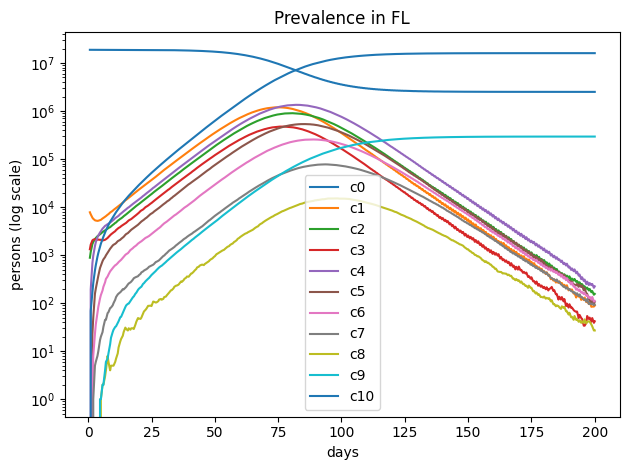

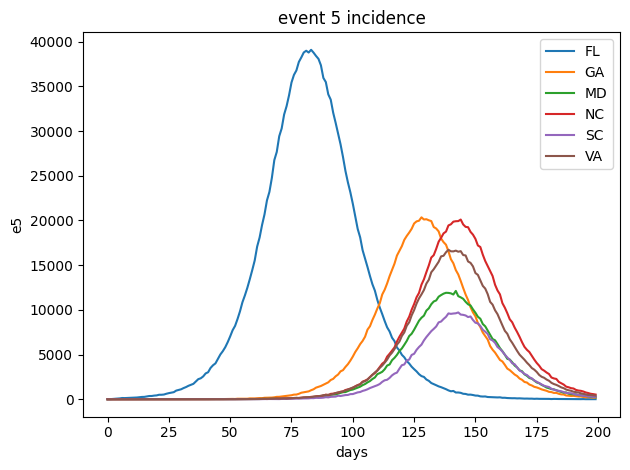

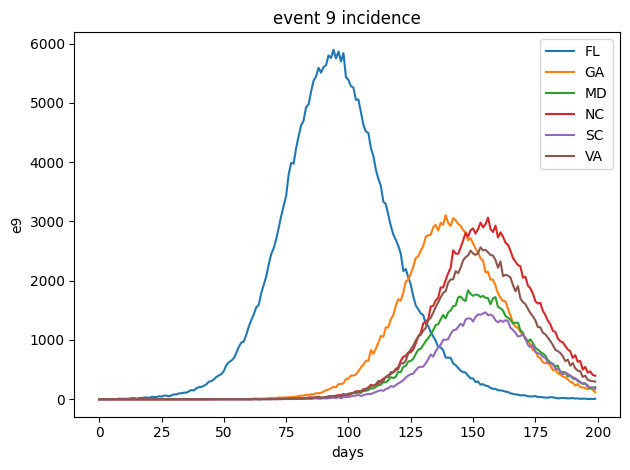

In [3]:
from datetime import date

from epymorph.data import geo_library, mm_library
from epymorph.run import plot_event, plot_pop
from epymorph.simulation import Simulation

# Run simulation

sim = Simulation(
    geo_library['pei'](),
    ipm_builder,
    mm_library['pei']())

out = sim.run(
    param={
        'infection_seed_loc': 0,
        'infection_seed_size': 10000,
        'move_control': 1,
        'theta': 0.1,
        'beta_1': 0.3,
        'omega_1': 0.55,
        'omega_2': 0.05,
        'delta_1': 0.333,
        'delta_2': 0.5,
        'delta_3': 0.166,
        'delta_4': 0.142,
        'delta_5': 0.125,
        'gamma_a': 0.166,
        'gamma_b': 0.333,
        'gamma_c': 0.25,
        'rho_1': 0.4,
        'rho_2': 0.175,
        'rho_3': 0.015,
        'rho_4': 0.2,
        'rho_5': 0.6,
    },
    start_date=date(2015, 1, 1),
    duration_days=200,
)

plot_pop(out, 0) # Florida prevalence

plot_event(out, 5) # 5: Is->Ih: hospitalizations, non-ICU
plot_event(out, 9) # 9: Ic1->D: deaths
